In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import InteractiveShell
import random

# InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
RANDOM_STATE = 42

In [3]:
# import csv
csv_file = 'outlier_removed_processed_df_bigrams.csv'
stock_df = pd.read_csv(csv_file, index_col=0)

In [4]:
# for testing without 2020 q1 data
# remove_q1 = stock_df.filter(like='Q1', axis=0)
# stock_df = stock_df[~stock_df.index.isin(remove_q1.index)]

In [5]:
# import sklearn modules
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [6]:
quarter_market_returns = stock_df[['Outlier Removed Market Return', 'Qtr']].groupby('Qtr').mean()

In [7]:
# drop features needed only for classification
stock_df_reg = stock_df.drop(columns=['Entire Market Return', 'Outlier Removed Market Return', 'Beat Entire Market Return', 'Beat Outlier Removed Market Return'])

In [8]:
# randomly shuffle dataset
stock_df_reg = stock_df_reg.sample(random_state=RANDOM_STATE, frac=1)

In [9]:
# sort on quarter
stock_df_reg.sort_values(by='Qtr', ascending=True, inplace=True)

In [10]:
# split data to get a test data set
features = stock_df_reg.drop(columns='Next Qtr Return')
target = stock_df_reg['Next Qtr Return']

In [11]:
# get index of qtr changes
qtr_counts = features['Qtr'].value_counts().sort_index(ascending=True).cumsum()
qtr_train_index = round(qtr_counts*.85).astype(int)

In [12]:
# create custom time series split by quarter
my_cv = [
    (np.arange(0, qtr_train_index[0]-1), np.arange(qtr_train_index[0], qtr_counts[0]-1)),
    (np.arange(0, qtr_train_index[1]-1), np.arange(qtr_train_index[1], qtr_counts[1]-1)),
    (np.arange(0, qtr_train_index[2]-1), np.arange(qtr_train_index[2], qtr_counts[2]-1)),
    (np.arange(0, qtr_train_index[3]-1), np.arange(qtr_train_index[3], qtr_counts[3]))
]

In [13]:
# don't use qtr as a feature
features.drop(columns='Qtr', inplace=True)

In [14]:
# standard scale data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [15]:
def model_train_test(model, inp_params, model_name):
    scores = []
    best_model = model
    for q_num, (train, test) in enumerate(my_cv):
        if q_num == 0:
            qtr = '2019_Q2'
        elif q_num == 1:
            qtr = '2019_Q3'
        elif q_num == 2:
            qtr = '2019_Q4'
        else:
            qtr = '2020_Q1'

        qtr_f_train = features_scaled[train]
        qtr_f_test = features_scaled[test]
        qtr_t_train = target[train]
        qtr_t_test = target[test]

        # set up gridsearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=inp_params, scoring='neg_mean_squared_error')

        _ = grid_search.fit(qtr_f_train, qtr_t_train)

        print(grid_search.best_params_)
        best_model = grid_search.best_estimator_

        pred_train = best_model.predict(qtr_f_train)
        train_scores = (np.sqrt(mean_squared_error(qtr_t_train, pred_train)),r2_score(qtr_t_train, pred_train))
        print('{} RMSE on train set through {} is: {}'.format(model_name, qtr, train_scores[0]))
        print('{} R^2 on train set through {} is: {}'.format(model_name, qtr, train_scores[1]))

        pred_test = best_model.predict(qtr_f_test)
        test_scores = (np.sqrt(mean_squared_error(qtr_t_test, pred_test)),r2_score(qtr_t_test, pred_test))
        print('{} RMSE on test set through {} is: {}'.format(model_name, qtr, test_scores[0]))
        print('{} R^2 on test set through {} is: {}'.format(model_name, qtr, test_scores[1]))

        print('Number of features with a coefficient of 0 in {} is {}'.format(model_name, len(best_model.coef_[best_model.coef_ == 0])))
        scores.append((train_scores, test_scores))

    return best_model, scores


In [16]:
# initialize ridge reg
ridge_reg = Ridge(random_state=RANDOM_STATE)

# set parameter possibilities
params = {'alpha' : [100, 500, 1000, 5000, 10000, 50000]}

ridge_reg, ridge_reg_scores = model_train_test(ridge_reg, params, 'Ridge Regression')

{'alpha': 5000}
Ridge Regression RMSE on train set through 2019_Q2 is: 15.515912982547395
Ridge Regression R^2 on train set through 2019_Q2 is: 0.25133482910952143
Ridge Regression RMSE on test set through 2019_Q2 is: 16.597911855719513
Ridge Regression R^2 on test set through 2019_Q2 is: 0.14327193401654026
Number of features with a coefficient of 0 in Ridge Regression is 2
{'alpha': 5000}
Ridge Regression RMSE on train set through 2019_Q3 is: 19.778831210824663
Ridge Regression R^2 on train set through 2019_Q3 is: 0.1420587914025505
Ridge Regression RMSE on test set through 2019_Q3 is: 19.91066584589439
Ridge Regression R^2 on test set through 2019_Q3 is: -0.12254587056086397
Number of features with a coefficient of 0 in Ridge Regression is 2
{'alpha': 5000}
Ridge Regression RMSE on train set through 2019_Q4 is: 24.17383471553547
Ridge Regression R^2 on train set through 2019_Q4 is: 0.16508516369443893
Ridge Regression RMSE on test set through 2019_Q4 is: 33.65345333828373
Ridge Regr

In [17]:
# initialize lasso reg
lasso_reg = Lasso(random_state=RANDOM_STATE, max_iter=5000, tol=1e-3)

# set parameter possibilities
params = {'alpha' : [.5, .75, 1, 1.25, 1.5, 2],
          'fit_intercept' : [True, False]}

lasso_reg, lasso_reg_scores = model_train_test(lasso_reg, params, 'Lasso Regression')

{'alpha': 1, 'fit_intercept': True}
Lasso Regression RMSE on train set through 2019_Q2 is: 15.817569189911888
Lasso Regression R^2 on train set through 2019_Q2 is: 0.22194115415586568
Lasso Regression RMSE on test set through 2019_Q2 is: 16.457619703915437
Lasso Regression R^2 on test set through 2019_Q2 is: 0.15769353941973296
Number of features with a coefficient of 0 in Lasso Regression is 694
{'alpha': 0.75, 'fit_intercept': True}
Lasso Regression RMSE on train set through 2019_Q3 is: 19.77873921818222
Lasso Regression R^2 on train set through 2019_Q3 is: 0.14206677206576124
Lasso Regression RMSE on test set through 2019_Q3 is: 18.8965858560997
Lasso Regression R^2 on test set through 2019_Q3 is: -0.01111189378555899
Number of features with a coefficient of 0 in Lasso Regression is 709
{'alpha': 1.25, 'fit_intercept': False}
Lasso Regression RMSE on train set through 2019_Q4 is: 24.96878348611721
Lasso Regression R^2 on train set through 2019_Q4 is: 0.1092704739871454
Lasso Regress

In [18]:
# initialize elastic net reg
elastic_reg = ElasticNet(random_state=RANDOM_STATE, max_iter=5000, tol=.5)

# set parameter possibilities
params = {'alpha' : [.5, 1, 5, 10],
          'l1_ratio' : [0, .33, .66, 1]}

elastic_reg, elastic_reg_scores = model_train_test(elastic_reg, params, 'Elastic Net Regression')

{'alpha': 5, 'l1_ratio': 0}
Elastic Net Regression RMSE on train set through 2019_Q2 is: 15.45979738385895
Elastic Net Regression R^2 on train set through 2019_Q2 is: 0.25674035353968405
Elastic Net Regression RMSE on test set through 2019_Q2 is: 16.5944450504881
Elastic Net Regression R^2 on test set through 2019_Q2 is: 0.14362978615885214
Number of features with a coefficient of 0 in Elastic Net Regression is 7
{'alpha': 1, 'l1_ratio': 1}
Elastic Net Regression RMSE on train set through 2019_Q3 is: 20.07126978078166
Elastic Net Regression R^2 on train set through 2019_Q3 is: 0.11650117440133423
Elastic Net Regression RMSE on test set through 2019_Q3 is: 18.952375629656846
Elastic Net Regression R^2 on test set through 2019_Q3 is: -0.01709106645451053
Number of features with a coefficient of 0 in Elastic Net Regression is 721
{'alpha': 1, 'l1_ratio': 1}
Elastic Net Regression RMSE on train set through 2019_Q4 is: 24.7280691359592
Elastic Net Regression R^2 on train set through 2019_Q4

In [19]:
# # initialize SGD reg
# sgd_reg = SGDRegressor(random_state=RANDOM_STATE, max_iter=5000)
#
# params = {'alpha' : [.1, .5, 1],
#           'l1_ratio' : [0, .1, .5, 1],
#           'penalty' : ['l1', 'l2']}
# # set parameter possibilities
# sgd_reg, sgd_reg_scores = model_train_test(sgd_reg, params, 'SGD Regression')
#

In [20]:
ridge_reg_train_scores = np.asarray(ridge_reg_scores)[:,0]
ridge_reg_test_scores = np.asarray(ridge_reg_scores)[:,1]
lasso_reg_train_scores = np.asarray(lasso_reg_scores)[:,0]
lasso_reg_test_scores = np.asarray(lasso_reg_scores)[:,1]
elastic_reg_train_scores = np.asarray(elastic_reg_scores)[:,0]
elastic_reg_test_scores = np.asarray(elastic_reg_scores)[:,1]
# sgd_reg_train_scores = np.asarray(sgd_reg_scores)[:,0]
# sgd_reg_test_scores = np.asarray(sgd_reg_scores)[:,1]

In [21]:
# create dict all regression scores
reg_score_dictionary = {'Ridge' : (ridge_reg_train_scores.mean(axis=0), ridge_reg_test_scores.mean(axis=0)), 'Lasso ' : (lasso_reg_train_scores.mean(axis=0), lasso_reg_test_scores.mean(axis=0) ), 'El. Net' : (elastic_reg_train_scores.mean(axis=0), elastic_reg_test_scores.mean(axis=0) )}

In [22]:
print('\t\t\tScores')
print('\t\tTrain\t\tTest')
for type in reg_score_dictionary:
    print('{}\t\tRMSE | {}\t| {}'.format(type, round(reg_score_dictionary[type][0][0],4), round(reg_score_dictionary[type][1][0],4)))
    print('\t\tR^2  | {}\t| {}'.format(round(reg_score_dictionary[type][0][1],4), round(reg_score_dictionary[type][1][1],4)))

			Scores
		Train		Test
Ridge		RMSE | 21.5027	| 25.1954
		R^2  | 0.1795	| -0.2927
Lasso 		RMSE | 21.7849	| 24.5531
		R^2  | 0.1577	| -0.241
El. Net		RMSE | 21.6522	| 24.3644
		R^2  | 0.1678	| -0.2104


In [23]:
# print visualization of best model (Elastic Rergression)
coef = pd.Series(elastic_reg.coef_, features.columns).sort_values()

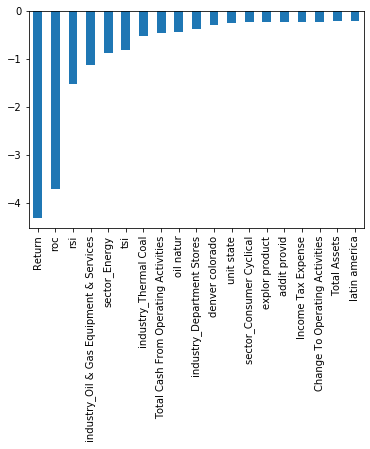

In [24]:
_ = coef[:19].plot(kind='bar')

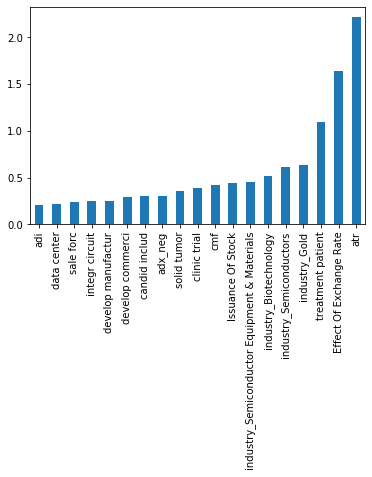

In [25]:
_ = coef[-19:].plot(kind='bar')

In [26]:
print('All Relevant Features:')
coef[coef != 0]

All Relevant Features:


Return                                    -4.324542
roc                                       -3.709459
rsi                                       -1.518498
industry_Oil & Gas Equipment & Services   -1.121626
sector_Energy                             -0.884929
                                             ...   
industry_Semiconductors                    0.616644
industry_Gold                              0.634628
treatment patient                          1.097973
Effect Of Exchange Rate                    1.644986
atr                                        2.215181
Length: 81, dtype: float64

In [27]:
def checkReturn(pred_vals, true_vals, qtr):
    # see what hypothetical return would be by picking stocks that were predicted to have positive returns
    stocks_taken = []
    for i, ret_val in enumerate(pred_vals):
        if ret_val > 0:
            stocks_taken.append(true_vals[i])

    our_return = round(sum(stocks_taken) / len(stocks_taken),2)
    market_return = round(np.mean(true_vals),2)

    print('\n{}:'.format(qtr))
    print('\tTotal return of all positive predicted return stocks:   {}'.format(our_return))
    print('\tTotal return of all stocks in test set: \t\t{}'.format(market_return))
    print('\tReturn over market based on best model: \t\t{}\n'.format(round(our_return - market_return,2)))
    return round((our_return - market_return),2)


2019_Q2:
	Total return of all positive predicted return stocks:   2.67
	Total return of all stocks in test set: 		-3.69
	Return over market based on best model: 		6.36


2019_Q3:
	Total return of all positive predicted return stocks:   10.3
	Total return of all stocks in test set: 		10.23
	Return over market based on best model: 		0.07


2019_Q4:
	Total return of all positive predicted return stocks:   -22.5
	Total return of all stocks in test set: 		-29.44
	Return over market based on best model: 		6.94


2020_Q1:
	Total return of all positive predicted return stocks:   17.74
	Total return of all stocks in test set: 		16.16
	Return over market based on best model: 		1.58

Overall return over market: 3.74


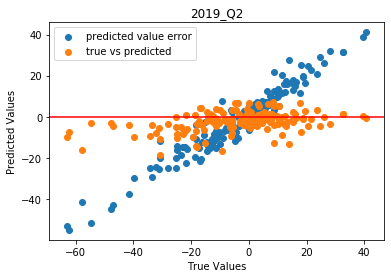

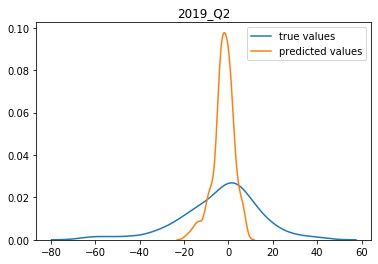

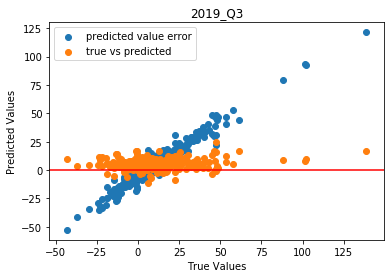

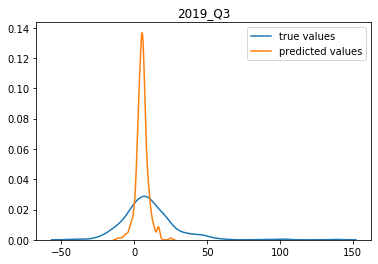

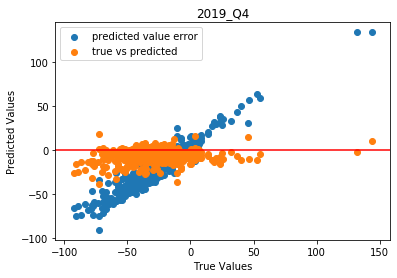

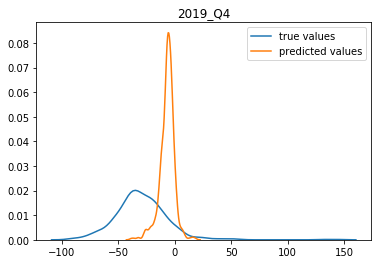

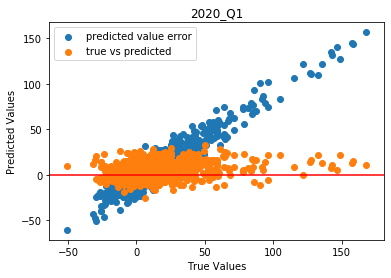

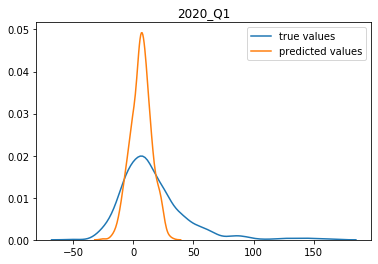

In [29]:
return_over_market = 0
for q_num, (train, test) in enumerate(my_cv):
    if q_num == 0:
        qtr = '2019_Q2'
    elif q_num == 1:
        qtr = '2019_Q3'
    elif q_num == 2:
        qtr = '2019_Q4'
    else:
        qtr = '2020_Q1'

    qtr_f_train = features_scaled[train]
    qtr_f_test = features_scaled[test]
    qtr_t_train = target[train]
    qtr_t_test = target[test]

    # initialize elastic net reg
    elastic_reg = ElasticNet(random_state=RANDOM_STATE, max_iter=5000, tol=.5)

    # set parameter possibilities
    params = {'alpha' : [.5, 1, 5, 10],
              'l1_ratio' : [0, .33, .66, 1]}

     # set up gridsearchCV
    grid_search = GridSearchCV(estimator=elastic_reg, param_grid=params, scoring='neg_mean_squared_error')

    _ = grid_search.fit(qtr_f_train, qtr_t_train)

    elastic_reg = grid_search.best_estimator_
    pred_test = elastic_reg.predict(qtr_f_test)

    return_over_market += checkReturn(pred_test, qtr_t_test, qtr)

    fig, ax = plt.subplots()
    _ = ax.scatter(qtr_t_test, (qtr_t_test - pred_test), label='predicted value error')
    _ = ax.scatter(qtr_t_test, pred_test, label='true vs predicted')
    _ = plt.axhline(y=0, color='r', linestyle='-')
    _ = plt.xlabel('True Values')
    _ = plt.ylabel('Predicted Values')
    _ = plt.legend()
    _ = plt.title('{}'.format(qtr))
    plt.show()


    _ = sns.kdeplot(qtr_t_test, label='true values')
    _ = sns.kdeplot(pred_test, label='predicted values')
    _ = plt.legend()
    _ = plt.title('{}'.format(qtr))
    plt.show()

print('Overall return over market: {}'.format(round(return_over_market / 4,2)))